# Outcome measured with uncertainty 

In real life, the outcome of interest is measured with imperfect test. Misclassification induced by such an imperfect diagnostic test will lead to biased estimates of the odds ratios and their variances. In that regard, it is important to consider sensitivity and specificity of the diagnostic. Prior information of these quantities lead to a bivariate analysis [1]. This notebook intends to use a bivariate Beta distribution built in [2]. I am going to use data from a Meta-analysis in which the telomerase
marker is used to diagnose bladder cancer taken from [3]. 

In [19]:
import pandas as pd 
import numpy as np

from scipy.special import gamma
from scipy.integrate import quad

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

We have data of True Positives (TP), False Negatives (FN), True Negatives (TN), and False Positives (FP). Note that the empirical estimator of sensitivity $\gamma_s$ is 

$$
\hat{\gamma}_s = \frac{TP}{TP + FN}
$$

and of especificity $\gamma_e$ is 

$$
\hat{\gamma}_e = \frac{TN}{TN + FP}.
$$

The initial ideia is to use the estimators from different studies and to use this information in the bivariate beta ditribution. 

In [8]:
studies = pd.read_csv('../../data/telomerase_meta_analysis.csv')
studies

,Study,TP,FN,TN,FP
0,Ito et al. (1998),25,8,25,1
1,Rahat et al. (1999),17,4,11,3
2,Kavaler et al. (1998),88,16,31,16
3,Yoshida et al. (1997),16,10,80,3
4,Ramakumar et al. (1999),40,17,137,1
5,Landman et al. (1998),38,9,24,6
6,Kinoshita et al. (1997),23,19,12,0
7,Gelmini et al. (2000),27,6,18,2
8,Cheng et al. (2000),14,3,29,3
9,Cassel et al. (2001),37,7,7,22


In [12]:
studies['sens'] = studies['TP']/(studies['TP'] + studies['FN'])
studies['spec'] = studies['TN']/(studies['TN'] + studies['FP'])

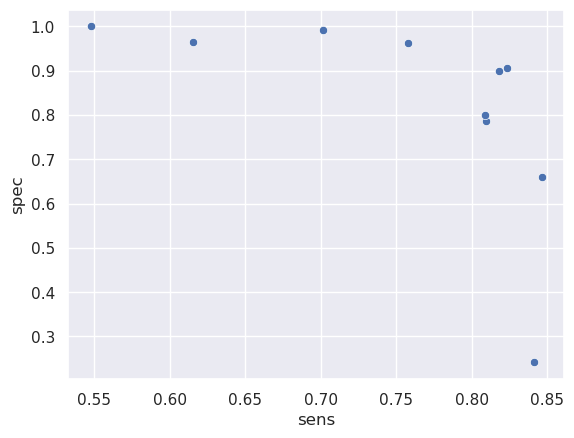

In [18]:
sns.scatterplot(x = 'sens', y = 'spec', data = studies)
plt.show()

## Bivariate Beta

Let $U = (U_1, U_2, U_3, U_4) \sim
\operatorname{Dirichlet}(\boldsymbol{\alpha})$, where $\boldsymbol{\alpha} =
(\alpha_1, \alpha_2, \alpha_3, \alpha_4)$ and $U_4 = 1 - U_1 + U_2 + U_3$.
Therefore the joint density of $U$ is 

\begin{equation}
  f_U(u_1, u_2, u_3) = \frac{1}{B(\alpha_1,\alpha_2,\alpha_3,\alpha_4)}u_1^{\alpha_1-1}u_2^{\alpha_2-1}u_3^{\alpha_3-1}(1-u_1-u_2-u_3)^{\alpha_4-1}, 
\end{equation}

where $u_i \in [0,1], i = 1,2,3$, $u_1 + u_2 + u_3 \le 1$, $\alpha_i > 0, i =
1,...,4$ and for $v \in \mathbb{R}^n$,

$$B(v) = \frac{\prod_{i=1}^n \Gamma(v_i)}{\Gamma\left(\sum_{i=1}^n v_i\right)}.$$ 

Define
\begin{equation}
  X = U_1 + U_2 \text{ and } Y = U_1 + U_3.
\end{equation} 

The joint ditribution of $(X,Y)$ with domain $\Omega = \{u_{1} : \max(0, x + y - 1) < u_{1} < \min(x, y)\}$ is bivariate beta. 

I remember that the choice of all parameters to be less than one can lead to convergence problems, specially when $x=y$. 

In [20]:
constant_factor = lambda alpha: gamma(alpha).prod()/gamma(alpha.sum())

def f_u(u, x, y, alpha): 
    
    if (u == 0) or (u == x) or (u == y) or (u == x+y-1): 
        return 0
    
    fun  = u**(alpha[0]-1)
    fun *= (x-u)**(alpha[1]-1)
    fun *= (y-u)**(alpha[2]-1)
    fun *= (1-x-y+u)**(alpha[3]-1)
    
    return fun

def bivariate_beta_pdf(x, y, alpha): 
    
    if (x==0) or (y==0) or (x==1) or (y==1): 
        return 0
    
    c = constant_factor(alpha)
    
    lb = max(0,x+y-1)
    ub = min(x,y)
            
    return quad(f_u, lb, ub, args=(x,y,alpha))/c

We have that 

\begin{align*}
    X &\sim \operatorname{Beta}(\alpha_1 + \alpha_2, \alpha_3 + \alpha_4) \\
    Y &\sim \operatorname{Beta}(\alpha_1 + \alpha_3, \alpha_2 + \alpha_4) \\
    \operatorname{E}(X) &= \operatorname{E}(U_1 + U_2) = \frac{\alpha_1+\alpha_2}{\alpha_1+\alpha_2+\alpha_3+\alpha_4} \\
    \operatorname{E}(Y) &= \operatorname{E}(U_1 + U_3) = \frac{\alpha_1+\alpha_3}{\alpha_1+\alpha_2+\alpha_3+\alpha_4} \\
    \operatorname{Var}(X) &= \operatorname{Cov}(U_1+U_2, U_1+U_2) = \frac{1}{\tilde{\alpha}^2(\tilde{\alpha}+1)}(\alpha_1+\alpha_2)(\alpha_3 + \alpha_4) \\
    \operatorname{Var}(Y) &= \operatorname{Cov}(U_1+U_3, U_1+U_3) = \frac{1}{\tilde{\alpha}^2(\tilde{\alpha}+1)}(\alpha_1+\alpha_3)(\alpha_2 + \alpha_4)  \\ 
    \operatorname{Cov}(X,Y) &= \operatorname{Cov}(U_1+U_2, U_1+U_3) = \frac{1}{\tilde{\alpha}^2(\tilde{\alpha}+1)}(\alpha_1\alpha_4 - \alpha_2\alpha_3) \\
    \operatorname{Cor}(X,Y) &= \frac{\operatorname{Cov}(X,Y)}{\sqrt{\operatorname{Var}(X)\operatorname{Var}(Y)}} = \frac{\alpha_1\alpha_4 - \alpha_2\alpha_3}{\sqrt{(\alpha_1+\alpha_2)(\alpha_3+\alpha_4)(\alpha_1+\alpha_3)(\alpha_2+\alpha_4)}}
\end{align*}

## References 

[1] Guo, J., Riebler, A., and Rue, H. (2017) Bayesian bivariate meta-analysis of diagnostic test studies with interpretable priors. Statist. Med., 36: 3039– 3058. doi: 10.1002/sim.7313.

[2] Olkin, Ingram & Trikalinos, Thomas. (2014). Constructions for a bivariate beta distribution. Statistics & Probability Letters. 96. 10.1016/j.spl.2014.09.013. 

[3] Glas AS, Roos D, Deutekom M, Zwinderman AH, Bossuyt PMM, Kurth KH. Tumor markers in the diagnosis of primary bladder cancer. A systematic review. The Journal of Urology 2003; 169(6):1975–1982.